In [1]:
!pip install ultralytics --quiet

from ultralytics import YOLO
import torch
import os
os.environ["WANDB_DISABLED"] = "true"

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.0 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 6.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.0 MB/s eta 0:00:00:00:0100:01
Creating new Ultralytic

In [2]:
%cd /kaggle/working

!mkdir -p coco
%cd coco

# val2017 images + annotations (5k images)
!wget -q http://images.cocodataset.org/zips/val2017.zip
!wget -q http://images.cocodataset.org/annotations/annotations_trainval2017.zip

!unzip -q val2017.zip
!unzip -q annotations_trainval2017.zip

/kaggle/working
/kaggle/working/coco


In [3]:
import os, json, random, shutil
from pathlib import Path
from collections import defaultdict

random.seed(42)

SRC_IMG = "/kaggle/working/coco/val2017"
ANN_FILE = "/kaggle/working/coco/annotations/instances_val2017.json"
ROOT = "/kaggle/working/coco_person_v5"  # new folder for this experiment

# target dirs
train_img_dir = os.path.join(ROOT, "images", "train")
val_img_dir   = os.path.join(ROOT, "images", "val")
train_lbl_dir = os.path.join(ROOT, "labels", "train")
val_lbl_dir   = os.path.join(ROOT, "labels", "val")
for d in [train_img_dir, val_img_dir, train_lbl_dir, val_lbl_dir]:
    os.makedirs(d, exist_ok=True)

# load COCO
with open(ANN_FILE, "r") as f:
    coco = json.load(f)
imgs = coco["images"]
anns = coco["annotations"]

# keep only images that have at least one person
PERSON_CAT_ID = 1
per_image = defaultdict(list)
for a in anns:
    if a["category_id"] == PERSON_CAT_ID:
        per_image[a["image_id"]].append(a)

person_imgs = [im for im in imgs if im["id"] in per_image]
all_files = [im["file_name"] for im in person_imgs]
random.shuffle(all_files)

# 80/20 split
split = int(0.8 * len(all_files))
train_files, val_files = all_files[:split], all_files[split:]

# copy images
for fn in train_files:
    shutil.copy(os.path.join(SRC_IMG, fn), os.path.join(train_img_dir, fn))
for fn in val_files:
    shutil.copy(os.path.join(SRC_IMG, fn), os.path.join(val_img_dir, fn))

# make labels
id_by_name = {im["file_name"]: im for im in imgs}
def write_labels(files, lbl_dir):
    count=0
    for fn in files:
        im = id_by_name[fn]
        W, H = im["width"], im["height"]
        lines=[]
        for a in per_image.get(im["id"], []):
            x,y,w,h = a["bbox"]
            xc = (x + w/2) / W
            yc = (y + h/2) / H
            wn = w / W
            hn = h / H
            lines.append(f"0 {xc:.6f} {yc:.6f} {wn:.6f} {hn:.6f}")
        with open(os.path.join(lbl_dir, Path(fn).stem + ".txt"), "w") as f:
            f.write("\n".join(lines))
        count += 1
    return count

t = write_labels(train_files, train_lbl_dir)
v = write_labels(val_files,   val_lbl_dir)

print(f"Person images: total={len(all_files)} | train={len(train_files)} | val={len(val_files)}")
print(f"Labels written: train={t} val={v}")


Person images: total=2693 | train=2154 | val=539
Labels written: train=2154 val=539


In [4]:
yaml_text = f"""path: {ROOT}
train: images/train
val: images/val
nc: 1
names: [person]
"""
with open("/kaggle/working/person_v5.yaml", "w") as f:
    f.write(yaml_text)
print("YAML -> /kaggle/working/person_v5.yaml")

YAML -> /kaggle/working/person_v5.yaml


In [5]:
%cd /kaggle/working
!git clone -q https://github.com/ultralytics/yolov5.git
%cd yolov5
!pip install -q -r requirements.txt


/kaggle/working
/kaggle/working/yolov5


In [6]:
%cd /kaggle/working/yolov5
!python train.py \
  --img 640 \
  --batch 16 \
  --epochs 100 \
  --data /kaggle/working/person_v5.yaml \
  --weights yolov5l.pt \
  --name yolov5_person


/kaggle/working/yolov5
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-09-29 14:36:42.697042: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759156602.901158      97 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759156602.962742      97 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
wandb: WARNING If you're specifying your api key in cod

In [7]:
!python val.py \
  --weights runs/train/yolov5_person/weights/best.pt \
  --data /kaggle/working/person_v5.yaml \
  --img 640


val: data=/kaggle/working/person_v5.yaml, weights=['runs/train/yolov5_person/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-432-g725b922e Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 267 layers, 46108278 parameters, 0 gradients, 107.6 GFLOPs
val: Scanning /kaggle/working/coco_person_v5/labels/val.cache... 539 images, 0 b
                 Class     Images  Instances          P          R      mAP50   
                   all        539       2301      0.801      0.637      0.715      0.484
Speed: 0.2ms pre-process, 22.2ms inference, 1.1ms NMS per image at shape (32, 3, 640, 640)
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value

Cleaned Columns:
 ['epoch', 'train/box_loss', 'train/obj_loss', 'train/cls_loss', 'metrics/precision', 'metrics/recall', 'metrics/mAP_0.5', 'metrics/mAP_0.5:0.95', 'val/box_loss', 'val/obj_loss', 'val/cls_loss', 'x/lr0', 'x/lr1', 'x/lr2']


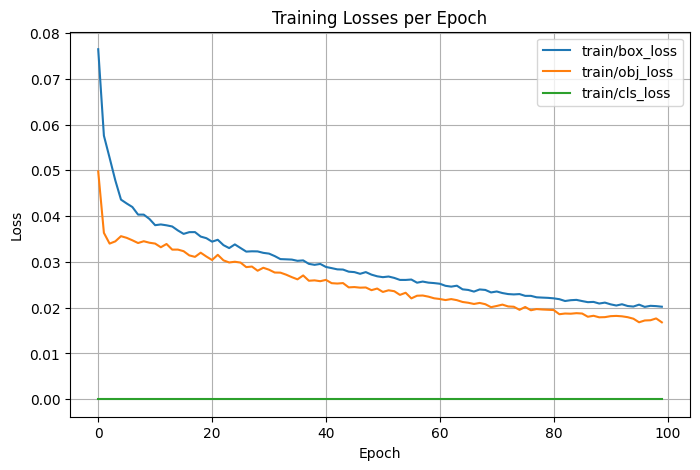

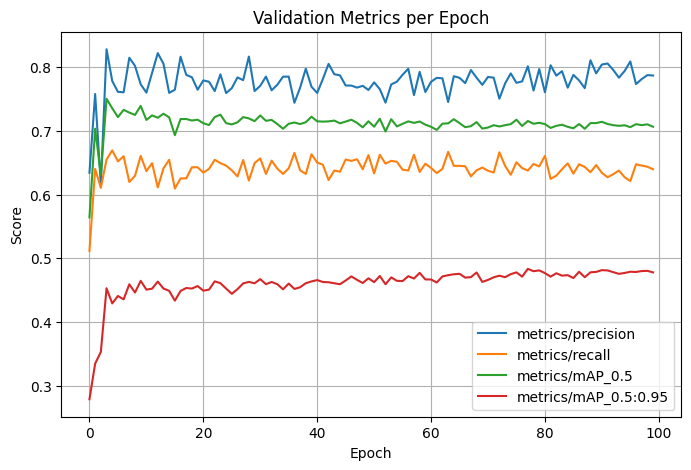

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

csv_path = '/kaggle/working/yolov5/runs/train/yolov5_person/results.csv'
df = pd.read_csv(csv_path)

# remove leading/trailing whitespace from column names
df.columns = df.columns.str.strip()

print("Cleaned Columns:\n", df.columns.tolist())

# Training losses
loss_cols = ['train/box_loss', 'train/obj_loss', 'train/cls_loss']
existing_losses = [c for c in loss_cols if c in df.columns]

if existing_losses:
    df[existing_losses].plot(figsize=(8,5), title='Training Losses per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

# Validation metrics
metric_cols = ['metrics/precision', 'metrics/recall', 'metrics/mAP_0.5', 'metrics/mAP_0.5:0.95']
existing_metrics = [c for c in metric_cols if c in df.columns]

if existing_metrics:
    df[existing_metrics].plot(figsize=(8,5), title='Validation Metrics per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.grid(True)
    plt.show()



In [12]:
import shutil, os
best = "/kaggle/working/yolov5/runs/train/yolov5_person/weights/best.pt"
dst  = "/kaggle/working/yolov5_person_best.pt"
shutil.copy(best, dst)
print("Saved:", dst)


Saved: /kaggle/working/yolov5_person_best.pt


In [15]:
!zip -r model_export.zip /kaggle/working/yolov5/runs/train/yolov5_person/weights/best.pt /kaggle/working/person_v5.yaml

  adding: kaggle/working/yolov5/runs/train/yolov5_person/weights/best.pt (deflated 8%)
  adding: kaggle/working/person_v5.yaml (deflated 15%)
